# CNN Training of DeepInsight Data
**Author:** Puxin
 
**Latest version date:** 2024-11-17  


In [1]:
import torch

**Usage of GPU**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Reproducibility**

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
import random
import numpy as np

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

set_seed(42)

**Original input image**

In [6]:
from PIL import Image

# Load the image
image = Image.open('/kaggle/input/deepinsight/DeepInsight/benign/sample1.png')

# Check the image mode
print("This image is not RGB") if image.mode != 'RGB' else print("This image is RGB")
print("Image mode:", image.mode)

This image is not RGB
Image mode: I;16


**Load images**

In [7]:
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
def convert_I_mode(image):
    # Convert 'I' mode images to 'L'
    if image.mode == 'I':
        image = image.convert('L')
    return image

In [9]:
# Define the transformations
# Convert to grayscale, 16x16 resize to 64x64, and convert to tensor
transform = transforms.Compose([
    transforms.Lambda(convert_I_mode),            # Custom transformation
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),                  # Resize to 64x64
    transforms.ToTensor(),                        # Convert image to tensor
])

In [10]:
dataset_path = "/kaggle/input/deepinsight/DeepInsight"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [11]:
# Get a dictionary associating the class index with the class name
target_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(target_to_class)

{0: 'benign', 1: 'malign'}


In [12]:
from collections import Counter

# Get the labels from the dataset
labels = dataset.targets

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the counts for each label
print(f"Classes: {dataset.classes}")
for label, count in label_counts.items():
    class_name = dataset.classes[label]  # Get class name from label index
    print(f"Class: {class_name}, Count: {count}")

Classes: ['benign', 'malign']
Class: benign, Count: 3000
Class: malign, Count: 1465


**Split the data: stratified split**

In [13]:
from sklearn.model_selection import train_test_split
labels = dataset.targets

train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=labels)

In [14]:
print(f"Training set count: {len(train_idx)}")
print(f"test set count: {len(test_idx)}")

Training set count: 3572
test set count: 893


In [15]:
from torch.utils.data import Subset
# Subset dataset for train and test
train_dataset = Subset(dataset, train_idx)
test_dataset= Subset(dataset, test_idx)

# Dataloader for train and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # For reproducibility
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
for images, labels in train_loader:
    print(f"Images batch shape: {images.shape}")  # [batch_size, 1, H, W] for grayscale
    print(f"Labels batch: {labels}")
    break

Images batch shape: torch.Size([32, 1, 64, 64])
Labels batch: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0])


In [17]:
for images, labels in test_loader:
    print(f"Images batch shape: {images.shape}")  # [batch_size, 1, H, W] for grayscale
    print(f"Labels batch: {labels}")
    break

Images batch shape: torch.Size([32, 1, 64, 64])
Labels batch: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0])


**CNN**

In [18]:
import torch.nn.functional as F

In [ ]:
# Define the CNN architecture
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            
    nn.Flatten(),
    nn.Linear(64 * 15 * 15, 128),
    nn.ReLU(),
    nn.Linear(128, 1)).to(device)

In [ ]:
#loss
loss_fn = nn.BCEWithLogitsLoss() 

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [ ]:
def test_loss(model, test_loader):
    model.eval()           
    test_loss = 0.0
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images)
            loss = loss_fn(logits, labels.unsqueeze(1).float())
            test_loss += loss.item() * labels.size(0)
    
    # Compute average test loss
    avg_test_loss = test_loss / len(test_loader.dataset)
    return avg_test_loss

In [ ]:
num_epochs = 100
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels.unsqueeze(1).float())
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    
    # Test phase
    avg_test_loss = test_loss(model, test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    
    if avg_test_loss < 0.12:
        torch.save(model.state_dict(), f'cnn_model_DI_epoch{epoch}.pth')
        break

Epoch 1/100, Train Loss: 0.4997, Test Loss: 0.3880
Epoch 2/100, Train Loss: 0.3234, Test Loss: 0.2719
Epoch 3/100, Train Loss: 0.2634, Test Loss: 0.2357
Epoch 4/100, Train Loss: 0.2268, Test Loss: 0.2319
Epoch 5/100, Train Loss: 0.2049, Test Loss: 0.2078
Epoch 6/100, Train Loss: 0.1879, Test Loss: 0.1885
Epoch 7/100, Train Loss: 0.1659, Test Loss: 0.1559
Epoch 8/100, Train Loss: 0.1427, Test Loss: 0.1513
Epoch 9/100, Train Loss: 0.1365, Test Loss: 0.1441
Epoch 10/100, Train Loss: 0.1211, Test Loss: 0.1321
Epoch 11/100, Train Loss: 0.1106, Test Loss: 0.1284
Epoch 12/100, Train Loss: 0.1040, Test Loss: 0.1265
Epoch 13/100, Train Loss: 0.0999, Test Loss: 0.1291
Epoch 14/100, Train Loss: 0.0978, Test Loss: 0.1334
Epoch 15/100, Train Loss: 0.0963, Test Loss: 0.1284
Epoch 16/100, Train Loss: 0.0868, Test Loss: 0.1295
Epoch 17/100, Train Loss: 0.0817, Test Loss: 0.1411
Epoch 18/100, Train Loss: 0.0902, Test Loss: 0.1373
Epoch 19/100, Train Loss: 0.0830, Test Loss: 0.1483
Epoch 20/100, Train L

**Learning Curve**

In [24]:
import matplotlib.pyplot as plt

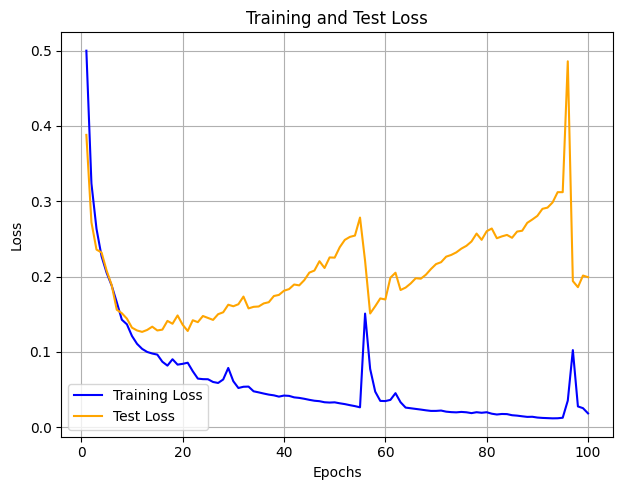

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='orange')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()